<img src="../assets/header_notebook.png" />
<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>ESA - Black Sea Deoxygenation Emulator</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# ----------
# Librairies
# ----------
import os
import sys
import cv2
import dawgz
import wandb
import xarray
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim

# Dawgz (jobs //)
from dawgz import job, schedule

# -------------------
# Librairies (Custom)
# -------------------
# Adding path to source folder to load custom modules
sys.path.insert(1, '../src/debs/')
sys.path.insert(1, '../scripts/')

# Loading libraries
from metrics              import *
from tools                import *
from dataset              import *
from dataloader           import *

# -------
# Jupyter
# -------
%matplotlib inline
plt.rcParams.update({'font.size': 13})

# Making sure modules are reloaded when modified
%reload_ext autoreload
%autoreload 2

# Moving to the .py directory
%cd ../src/debs/

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Scripts</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# Training a neural network:
%run training.py    --start_year                 0 \
                    --end_year                   0 \
                    --start_month                0 \
                    --end_month                  1 \
                    --inputs           temperature \
                    --problem       classification \
                    --windows_input              1 \
                    --windows_output             1 \
                    --depth                    200 \
                    --architecture         AVERAGE \
                    --scaling                    1 \
                    --loss_weights             1 1 \
                    --learning_rate          0.001 \
                    --batch_size                64 \
                    --epochs                     5 \
                    --kernel_size                3 \
                    --dawgz                  False

<hr style="color:#5A7D9F;">
<p align="center">
    <b style="font-size:2vw; color:#5A7D9F; font-weight:bold;">
    <center>Playground</center>
    </b>
</p>
<hr style="color:#5A7D9F;">

In [ ]:
# -----------------
#    Parameters
# -----------------
#
# Time window
month_starting = 0
month_ending   = 1
year_starting  = 0
year_ending    = 0

# Maximum depth observed for oxygen, what is left is masked [m] (Note: To observe only the continental shelf set it to ~200m).
depth_max_oxygen = 200

# ------------------
#  Loading the data
# ------------------
# Loading the different datasets
Dataset_phy = BlackSea_Dataset(year_start  = year_starting,
                               year_end    = year_ending,
                               month_start = month_starting,
                               month_end   = month_ending,
                               variable    = "grid_T")

Dataset_bio = BlackSea_Dataset(year_start  = year_starting,
                               year_end    = year_ending,
                               month_start = month_starting,
                               month_end   = month_ending,
                               variable    = "ptrc_T")

# Loading the different field values
data_temperature   = Dataset_phy.get_data(variable = "temperature", type = "surface", depth = None)
data_salinity      = Dataset_phy.get_data(variable = "salinity",    type = "surface", depth = None)
data_chlorophyll   = Dataset_bio.get_data(variable = "chlorophyll", type = "surface", depth = None)
data_kshort        = Dataset_bio.get_data(variable = "kshort",      type = "surface", depth = None)
data_klong         = Dataset_bio.get_data(variable = "klong",       type = "surface", depth = None)
data_oxygen        = Dataset_bio.get_data(variable = "oxygen",      type = "bottom" , depth = depth_max_oxygen)

# Loading the black sea masks
bs_mask             = Dataset_phy.get_mask(depth = None)
bs_mask_with_depth  = Dataset_phy.get_mask(depth = depth_max_oxygen)
bs_mask_complete    = get_complete_mask(data_oxygen, bs_mask_with_depth)

# --------------------
#  Preparing the data
# --------------------
# Loading the dataloader
BSD_loader = BlackSea_Dataloader(x = [data_temperature],
                                 y = data_oxygen,
                           bs_mask = bs_mask,
                bs_mask_with_depth = bs_mask_with_depth,
                              mode = "regression",
                        window_inp = 1,
                        window_out = 1)

# Retrieving the datasets
ds_validation = BSD_loader.get_dataloader("validation")
ds_train      = BSD_loader.get_dataloader("train")
ds_test       = BSD_loader.get_dataloader("test")

In [61]:
# -------------------------------------------------------
#
#        |
#       / \
#      / _ \                  ESA - PROJECT
#     |.o '.|
#     |'._.'|          BLACK SEA DEOXYGENATION EMULATOR
#     |     |
#   ,'|  |  |`.             BY VICTOR MANGELEER
#  /  |  |  |  \
#  |,-'--|--'-.|                2023-2024
#
#
# -------------------------------------------------------
#
# Documentation
# -------------
# A tool to load raw Black Sea datasets coming from the NEMO simulator.
#
import os
import xarray
import numpy as np
import json
from   tools import get_data_path, get_mesh_path


class BlackSea_Dataset():
    r"""A simple tool to load data of Black Sea simulations (NEMO Simulator)."""

    def __init__(self, year_start: int = 1980, year_end: int = 1980, month_start: int = 1, month_end: int = 1, folder:str = "output_HR001"):
        super().__init__()

        # Security (1)
        assert year_start  in [i for i in range(1980, 2023)], f"ERROR (Dataset, init) - Incorrect starting year ({year_start})"
        assert year_end    in [i for i in range(1980, 2023)], f"ERROR (Dataset, init) - Incorrect ending year ({year_end})"
        assert month_start in [i for i in range(1, 13)],      f"ERROR (Dataset, init) - Incorrect starting month ({month_start})"
        assert month_start in [i for i in range(1, 13)],      f"ERROR (Dataset, init) - Incorrect ending month ({month_end})"
        assert year_start <= year_end,                        f"ERROR (Dataset, init) - Incorrect years ({year_start} <= {year_end})"

        # Stores a list of useless variables, i.e. not usefull for our specific problem (for the sake of efficiency)
        self.useless_variables = ['time_centered',
                                  'deptht_bounds',
                                  'time_centered_bounds',
                                  'time_counter_bounds',
                                  'time_instant_bounds',
                                  'ssh', 'mldkz5', 'mldr10_1', 'mld_bs', 'rho', 'CCC', 'wfo',
                                  'qsr', 'qns', 'qt', 'sfx', 'taum', 'windsp', 'precip', 'bosp_Qout',
                                  'bosp_Qin', 'mmean_S_total', 'bosp_S_in', 'CFL', 'NFL', 'CEM', 'NEM',
                                  'CDI', 'NDI', 'MIC', 'MES', 'BAC', 'DCL', 'DNL', 'DCS', 'DNS', 'NOS',
                                  'NHS', 'SIO', 'DIC', 'ODU', 'POC', 'PON', 'SID', 'AGG', 'GEL', 'NOC',
                                  'PHO', 'SMI', 'CHA', 'CHD', 'CHE', 'CHF', 'PAR', 'NPP', 'NPPint', 'Carbon_UptakeDiatoms2D',
                                  'Nitrogen_UptakeDiatoms2D', 'Carbon_UptakeEmiliana2D','Nitrogen_UptakeEmiliana2D', 'Carbon_UptakeFlagellates2D',
                                  'Nitrogen_UptakeFlagellates2D', 'shearrate', 'sinkingDIA', 'sinkingPOM', 'pH', 'pCO2', 'AirSeaDICFlux', 'TA']

        # Loading (all) the dictionnaries containing the path to each dataset, i.e. "YEAR-MONTH : PATH(S)"
        with open('../../paths/data_grid_T.txt', 'r') as file:
            paths_physics_datasets_all = json.load(file)

        with open('../../paths/data_ptrc_T.txt', 'r') as file:
            paths_biogeochemistry_datasets_all = json.load(file)

        # Path to the folder containing the datasets
        self.datasets_folder = f"../../data/{folder}"

        # Stores all the relevant paths datasets
        self.paths_physics_datasets, self.paths_biogeochemistry_datasets = list(), list()

        # Extraction
        for year in range(year_start, year_end + 1):
            for month in range(month_start, month_end + 1):

                # Converting to strings
                year  = str(year)
                month = f"0{month}" if month < 10 else str(month)

                # Creation of the key
                key = f"{year}-{month}"

                # Retreiving the paths
                self.paths_physics_datasets         += [self.datasets_folder + p for p in paths_physics_datasets_all[key]]
                self.paths_biogeochemistry_datasets += [self.datasets_folder + p for p in paths_biogeochemistry_datasets_all[key]]

        # Saving other relevant information
        self.month_start = month_start
        self.month_end   = month_end
        self.year_end    = year_end
        self.year_start  = year_start
        self.folder      = folder

    def get_mesh(self, x: int, y: int):
        r"""Used to retrieve a mesh with normalized coordinates for the given shape (x, y)"""

        # Creation of the mesh
        x_mesh, y_mesh = np.meshgrid(np.linspace(0, 1, num = x), np.linspace(0, 1, num = y), indexing = 'ij')

        # Concatenation of the mesh (np.float32 is the type needed for torch when converted afterforwards)
        return np.stack((x_mesh, y_mesh), axis = 0, dtype = np.float32)

    def get_depth(self):
        r"""Used to retrieve the bathymetry information, i.e. the depth in [m] for each region of the sea (2D)"""

        # Path to the mesh file location
        path_mesh = get_mesh_path()

        # Loading the dataset containing information about the Black Sea mesh
        return xarray.open_dataset(path_mesh, engine = "h5netcdf").bathy_metry.data.astype('float32')

    def get_bathymetry(self):
        r"""Used to retrieve the bathymetry mask, i.e. the index at which we reach the bottom of the sea (2D)"""

        # Path to the mesh file location
        path_mesh = get_mesh_path()

        # Loading the dataset containing information about the Black Sea mesh
        return xarray.open_dataset(path_mesh, engine = "h5netcdf").mbathy.data

    def get_mask(self, depth: int = None):
        r"""Used to retreive a mask of the Black Sea, i.e. 0 if land, 1 if the Black Sea. If depth is given, it will also set to 0 all regions below that depth"""

        # Path to the mesh file location
        path_mesh = get_mesh_path()

        # Loading the dataset containing information about the Black Sea mesh
        mesh_data = xarray.open_dataset(path_mesh, engine = "h5netcdf")

        # Loading the complete Black sea mask
        bs_mask = mesh_data.tmask[0, 0].data

        # Checks if we want to hide regions below a given depth
        if not depth == None:

            # Retreives the bottom depth in [m] for each pixel
            depth_values = mesh_data.bathy_metry.data[0]

            # Remove all information for regions located below the given depth
            bs_mask[depth <= depth_values] = 0

        # Returning the processed mask
        return bs_mask

    def get_data(self, variable: str, level: int = None, region : str = None, depth: int = None):
        r"""Used to retreive the data for a given variable at a specific level or a specific region"""

        # Security (1)
        assert variable in ["temperature", "salinity", "oxygen", "chlorophyll", "kshort", "klong"], f"ERROR (get_data), Incorrect variable ({variable})"
        assert level  == None or (0 <= level and level < 59),                                       f"ERROR (get_data), Incorrect level (0 < {level} < 59)"
        assert region == None or region in ["surface", "bottom", "all"],                            f"ERROR (get_data), Incorrect region ({region})"

        # Security (2) - Choosing between level or region
        assert not (level == None and region == None), f"ERROR (get_data), You must specify either a level or a region"
        assert not (level != None and region != None), f"ERROR (get_data), You must specify either a level or a region, not both"

        def translate(variable: str):
            r"""Used to translate a variable into its name in the dataset, retrieve the type of dataset and the useless variables (the other ones)"""

            # Stores the translations for all the EO variables and oxygen
            translations = {"temperature" : ["votemper", "physics"],
                            "salinity"    : ["vosaline", "physics"],
                            "oxygen"      : ["DOX",      "biogeochemistry"],
                            "chlorophyll" : ["CHL",      "biogeochemistry"],
                            "kshort"      : ["KBIOS",    "biogeochemistry"],
                            "klong"       : ["KBIOL",    "biogeochemistry"]}

            # Retrieving translation
            v, v_type = translations[variable]

            # Returns also the useless variables
            return v, v_type, [values[0] for key, values in translations.items() if key != variable]

        def get_bottom(data: np.array, depth = None):
            r"""Used to retreive the data profile (2D) everywhere at the bottom of the Black Sea (None) of for all regions above a given depth"""

            # Security
            assert len(data.shape) == 4, f"ERROR (get_bottom), Incorrect data shape ({data.shape}), i.e. input dimensions should be (time, depth, y, x)"

            # Retreiving the bathymetry mask b(t, x, y) = z_bottom, i.e. index at which we found bottom of the sea
            bathy_mask = self.get_bathymetry()

            # Creation of x and y indexes to make manipulation
            x, y = np.arange(bathy_mask.shape[2]), np.arange(bathy_mask.shape[1])
            xidx = x.reshape(-1,1).repeat(len(y), axis = 1).T
            yidx = y.reshape(-1,1).repeat(len(x), axis = 1)

            # Retreiving the data everywhere at the bottom
            data = data[:, bathy_mask[0] - 1, yidx, xidx]

            # Hiding the regions below the given depth
            if not depth == None:
                data[:, self.get_mask(depth = depth) == 0] = np.nan

            return data

        # Translation
        variable, variable_type, other_useless_variables = translate(variable)

        # Loading the data (3D field)
        data = xarray.open_mfdataset(self.paths_physics_datasets if variable_type == "physics" else self.paths_biogeochemistry_datasets,
                                     engine         = "h5netcdf",
                                     parallel       = True,
                                     drop_variables = self.useless_variables + other_useless_variables)

        # Level, i.e. selecting a specific depth by its index
        if not level == None:
            return data[variable][:, level, :, :].data.compute()

        # All (3D)
        if region == "all":
            return data[variable][:, :, :, :].data.compute()

        # Surface (2D)
        if region == "surface":
            return data[variable][:, 0, :, :].data.compute()

        # Bottom (2D)
        if region == "bottom":
            return get_bottom(data[variable].data.compute(), depth = depth)



a = BlackSea_Dataset(year_start = 1980, year_end = 1980, month_end=2)
b = a.get_data("salinity", level = 2, region = "bottom", depth = 100)

AssertionError: ERROR (get_data), You must specify either a level or a region, not both

In [58]:
b.shape

(60, 258, 578)

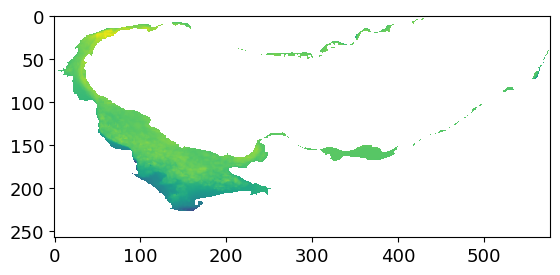

In [59]:
plt.imshow(b[0])